In [1]:
import numpy as np
import matplotlib.pylab as plt

In [11]:
plt.style.use('default')

In [2]:
N = 100 # number of sites

In [5]:
ess = -1 # single particle on site energy first orbital
bss = -1 # nearest neighbor hoping first orbital

In [8]:
def make(N, ess = ess, bss = bss):
    I = np.eye(N)
    H = ess * I + bss * (np.roll(I, 1, axis=0) + np.roll(I, -1, axis=0))
    return H

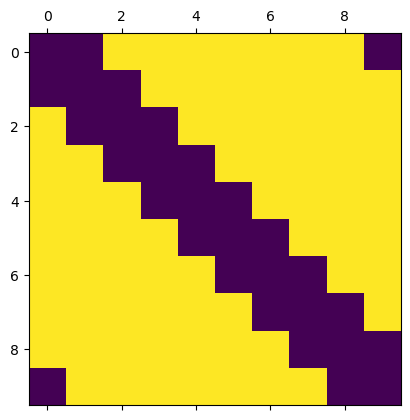

In [12]:
plt.matshow(make(10))

In [13]:
def solve(H):
    e, v = np.linalg.eigh(H)
    return e, v.T

In [14]:
e, v = solve(make(50))

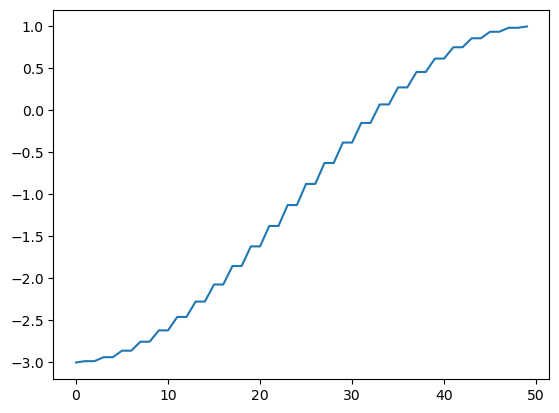

In [15]:
plt.plot(e)

# lets add stoner parameter for separate spin up/down hamil

In [17]:
def make(N, spins, J = .5, ess = ess, bss = bss):
    I = np.eye(N)
    H = (ess + J * spins) * I + bss * (np.roll(I, 1, axis=0) + np.roll(I, -1, axis=0))
    return H

Make ferromagnetic

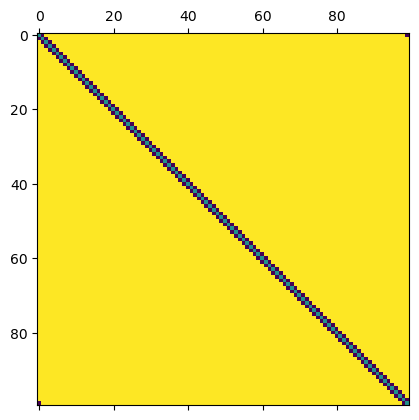

<Figure size 640x480 with 0 Axes>

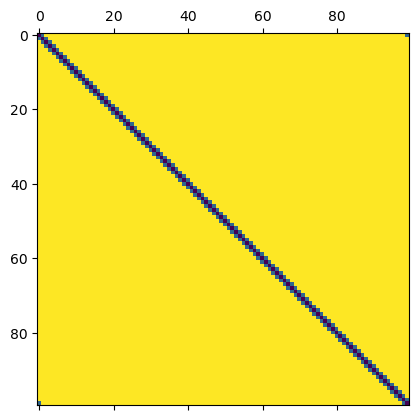

In [21]:
spins = np.ones(N)
Hu = make(N, spins)
Hd = make(N, -spins)
eu, vu = solve(Hu)
ed, vd = solve(Hd)
plt.matshow(Hu)
plt.figure()
plt.matshow(Hd)

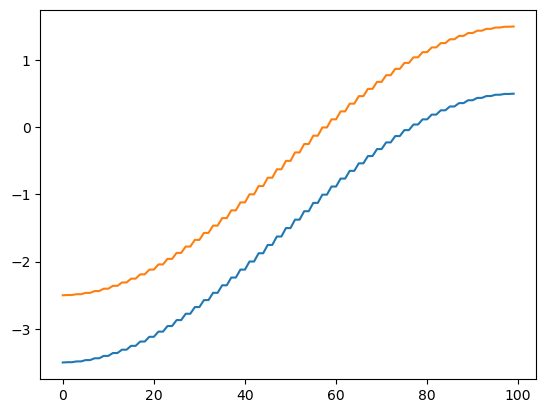

In [22]:
plt.plot(ed)
plt.plot(eu)

make anti-ferromagnetic

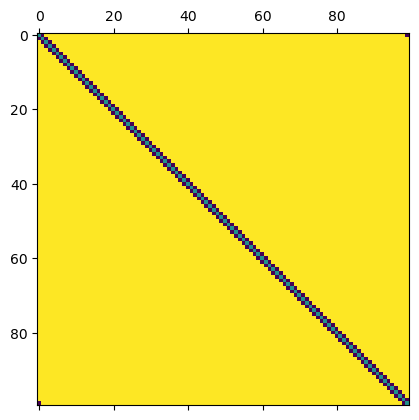

<Figure size 640x480 with 0 Axes>

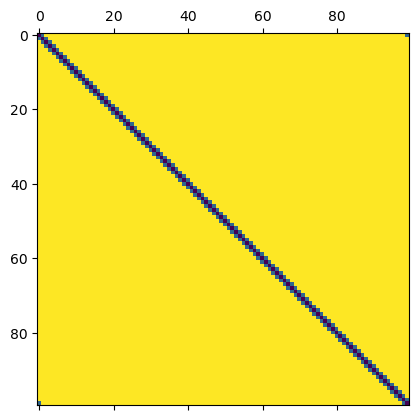

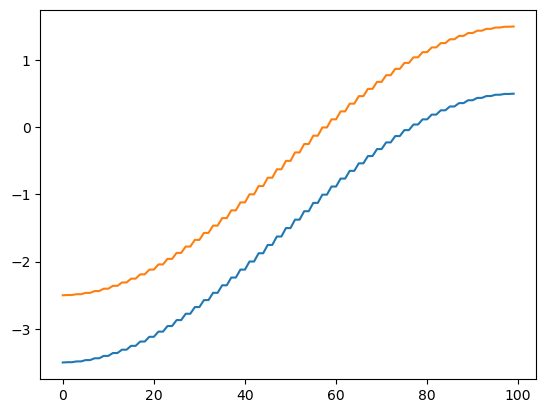

In [65]:
spins[::2] *= -1
Hu = make(N, spins)
Hd = make(N, -spins)
eu, vu = solve(Hu)
ed, vd = solve(Hd)
plt.matshow(Hu)
plt.figure()
plt.matshow(Hd)
plt.figure()
plt.plot(ed)
plt.plot(eu)

In [66]:
def occ(e, fermi, T):
    o = 1 / (1 + np.exp((e-fermi)/T))
    return o.sum(), o

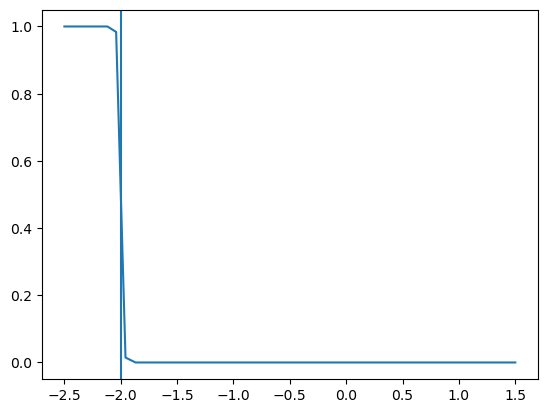

In [67]:
plt.plot(eu, occ(eu, -2, .01)[1])
plt.axvline(-2)

In [68]:
import scipy.optimize as so

In [70]:
np.ptp(eu)

4.0

In [71]:
def find_fermi(eu, ed, Ne, T):
    e = np.concatenate([eu, ed])
    return so.root(lambda fermi: occ(e, fermi, T)[0] - Ne, np.ptp(e)/2).x[0]

In [74]:
T = .1
fermi = find_fermi(eu, ed, N, T)

/u/system/SLES12/soft/pyiron/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


-1.0


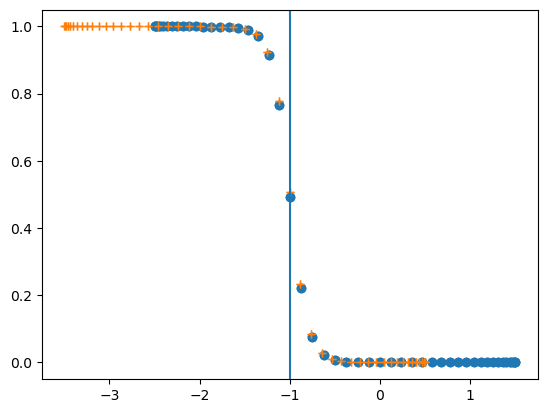

In [78]:
plt.plot(eu, occ(eu, fermi, T)[1], 'o')
plt.plot(ed, occ(ed, fermi, T)[1], '+')
plt.axvline(fermi)
print(fermi)

-1.0


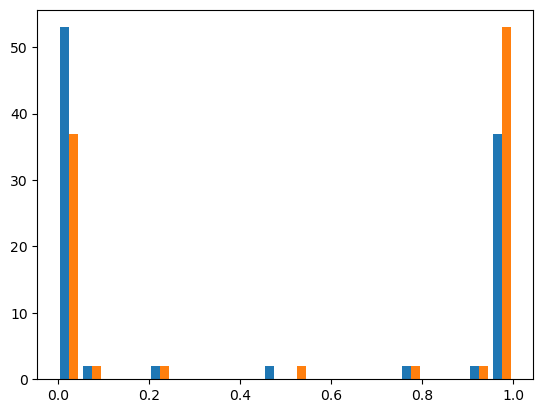

In [84]:
plt.hist([occ(eu, fermi, T)[1], occ(ed, fermi, T)[1]], bins=20)
print(fermi)

In [85]:
find_fermi?

Signature: find_fermi(eu, ed, Ne, T)
Docstring: <no docstring>
File:      /cmmc/u/zora/pyiron/projects/Journal/100221/<ipython-input-71-a8d6ab63072e>
Type:      function


In [86]:
occ?

Signature: occ(e, fermi, T)
Docstring: <no docstring>
File:      /cmmc/u/zora/pyiron/projects/Journal/100221/<ipython-input-66-c942db52109e>
Type:      function


In [89]:
def energy(eu, ed, Ne, T):
    fermi = find_fermi(eu, ed, Ne, T)
    return np.sum(eu * occ(eu, fermi, T)[1]) + np.sum(ed * occ(ed, fermi, T)[1])

/u/system/SLES12/soft/pyiron/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


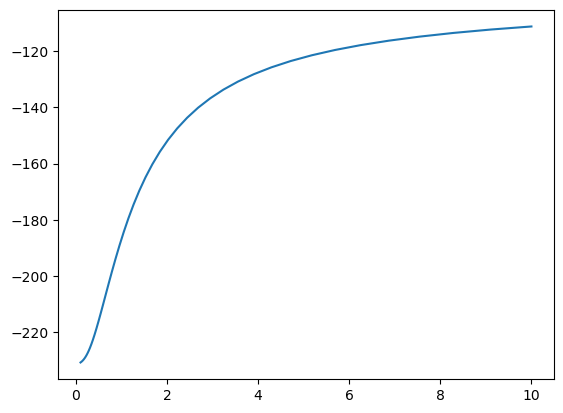

In [91]:
Ts = np.logspace(-1, 1)
plt.plot(Ts, [energy(eu, ed, 100, Ti) for Ti in Ts])

/u/system/SLES12/soft/pyiron/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


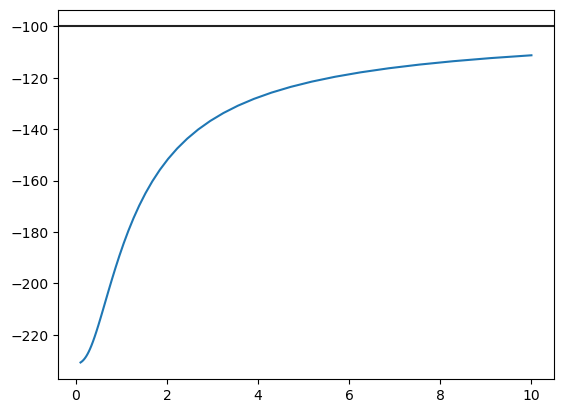

In [102]:
Ts = np.logspace(-1, 1)
Ne = 100
plt.plot(Ts, [energy(eu, ed, Ne, Ti) for Ti in Ts])
plt.axhline( (np.mean(eu) + np.mean(ed))/2*Ne, color='k' )

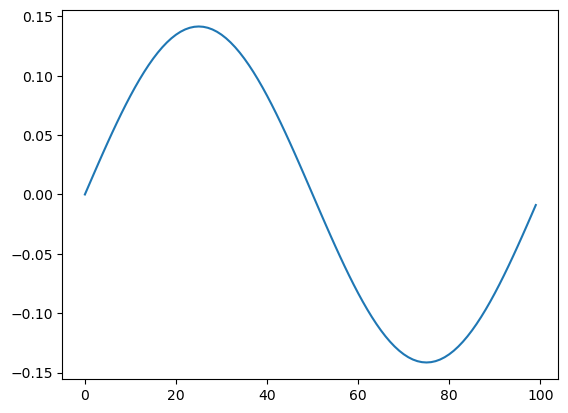

In [105]:
plt.plot(v[1])

In [106]:
find_fermi?

Signature: find_fermi(eu, ed, Ne, T)
Docstring: <no docstring>
File:      /cmmc/u/zora/pyiron/projects/Journal/100221/<ipython-input-71-a8d6ab63072e>
Type:      function


In [107]:
occ?

Signature: occ(e, fermi, T)
Docstring: <no docstring>
File:      /cmmc/u/zora/pyiron/projects/Journal/100221/<ipython-input-66-c942db52109e>
Type:      function


In [127]:
class TB:
    def __init__(self, N, Ne, spins, J=0.5, ess=1, bss=1):
        self.N = N
        self.Ne = Ne
        self.spins = spins
        self.J = J
        self.ess=ess
        self.bss=bss
        
    def solve(self, spins):
        self.Hu = make(N, +spins, J=self.J, ess=self.ess, bss=self.bss)
        self.Hd = make(N, -spins, J=self.J, ess=self.ess, bss=self.bss)
        self.eu, self.vu = solve(self.Hu)
        self.ed, self.vd = solve(self.Hd)
        self.e = np.concatenate([self.eu, self.ed])
        
    @property
    def T(self):
        return self._T
    
    @T.setter
    def T(self, v):
        self._T = v
        self.find_fermi(self.e)
        
    def find_fermi(self, e):
        self.fermi = so.root(lambda fermi: occ(e, fermi, self.T)[0] - self.Ne, np.ptp(e)/2).x[0]
        self.occ = occ(e, self.fermi, self.T)[1]
    
    def energy(self):
        return np.sum( self.e * occ(self.e, self.fermi, self.T) )

#     def mag_moments(self):
#         self.vu.outer occ(self.eu, self.fermi, T)
#         self.vd * occ(self.ed, self.fermi, T)

In [163]:
t = TB(100, 50, np.ones(100))

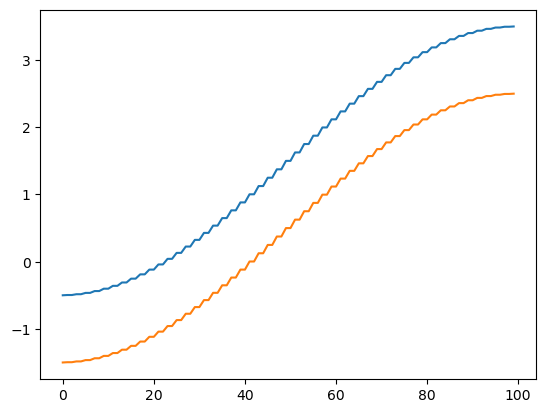

In [164]:
t.solve(t.spins)
plt.plot(t.eu)
plt.plot(t.ed)

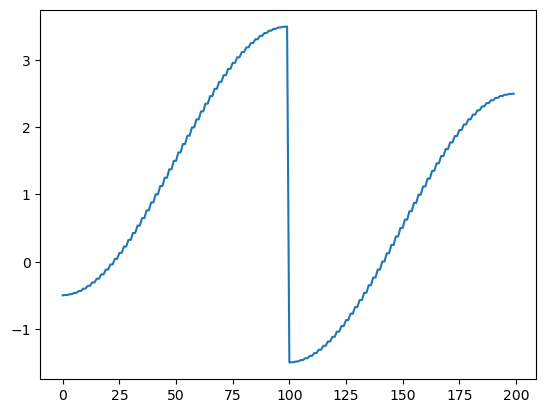

In [165]:
plt.plot(t.e)

In [166]:
t.T = .1

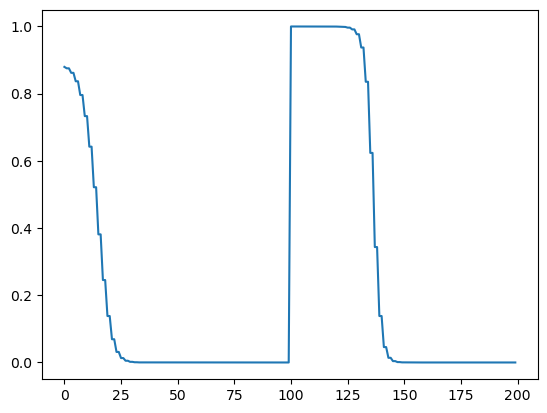

In [167]:
plt.plot(t.occ)

$|\langle i | \psi \rangle|^2 $

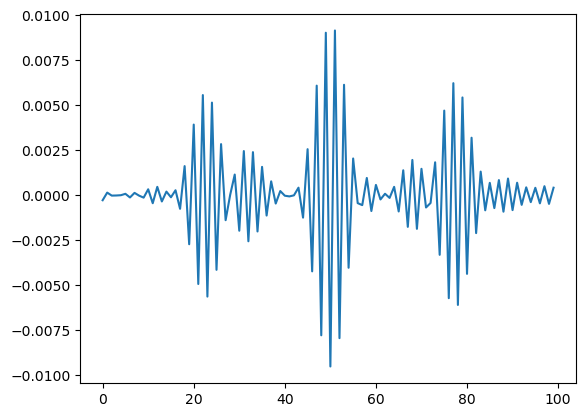

In [174]:
plt.plot(np.mean(t.vu * t.occ[:t.N, None], axis=0))

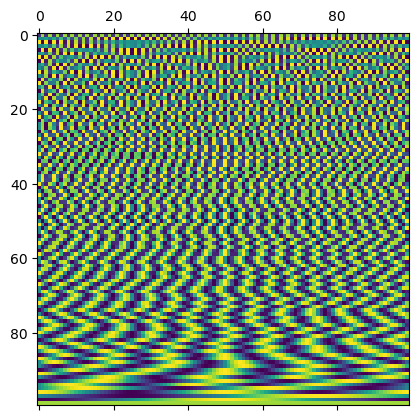

In [154]:
plt.matshow(t.vu)

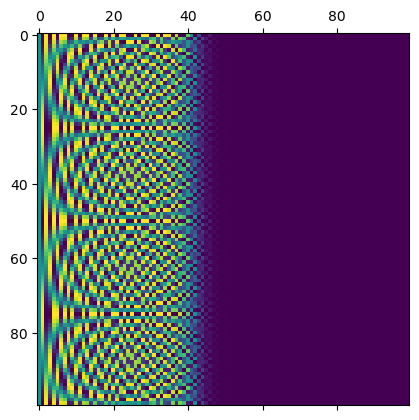

In [143]:
plt.matshow((t.vu.T)**2 * t.occ[:t.N])